# K-Nearest Neighbor Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [2]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', regression=False, normalize=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.regression = regression
        self.normalize = normalize

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        
        self.X = np.copy(data)
        self.y = np.copy(labels)
        
        if self.normalize:
            self.norms = np.zeros((2,self.X.shape[1]))
            for i in range(self.X.shape[1]):
                self.norms[0,i] = self.X[:,i].min()
                self.norms[1,i] = self.X[:,i].max()
                self.X[:,i] = (self.X[:,i] - self.norms[0,i]) / (self.norms[1,i] - self.norms[0,i])
        
        return self
    
    def predict(self, data_in, k):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        
        data = np.copy(data_in)
        
        prediction = []
        if not self.regression:
            classes = np.unique(self.y)
        
        if self.normalize:
            for i in range(data.shape[1]):
                data[:,i] = (data[:,i] - self.norms[0,i]) / (self.norms[1,i] - self.norms[0,i])

        for i in range(data.shape[0]):
            dist = np.zeros(self.X.shape[0])
            dist = np.linalg.norm(self.X - data[i], axis=1)
            nearest = np.zeros((k),int)
            alt_dist = np.copy(dist)
            if self.regression:
                ave = 0
                weight_sum = 0
            for n in range(nearest.shape[0]):
                nearest[n] = np.argmin(alt_dist)
                alt_dist[nearest[n]] = np.inf
                if self.regression:
                    if self.weight_type == 'inverse_distance':
                        ave += self.y[nearest[n]] / (dist[nearest[n]] ** 2)
                        weight_sum += 1 / (dist[nearest[n]] **2)
                    else:
                        ave += self.y[nearest[n]]
            if not self.regression:
                votes = np.zeros(classes.shape[0])
                for n in range(nearest.shape[0]):
                    vote = np.where(classes == self.y[nearest[n]])[0][0]
                    if self.weight_type == 'inverse_distance':
                        weight = 1 / (dist[n] ** 2)
                    else:
                        weight = 1
                    votes[vote] += weight
                prediction.append(classes[np.argmax(votes)])
            else:
                if self.weight_type == 'inverse_distance':
                    prediction.append(ave / weight_sum)
                else:
                    prediction.append(ave / k)
        return np.reshape(prediction, (-1,1))

    #Returns the Mean score given input data and labels
    def score(self, data, labels, k):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        
        predictions = self.predict(data, k)
        score = 0
        for i in range(labels.shape[0]):
            if self.regression:
                score += (labels[i] - predictions[i]) ** 2
            else:
                if labels[i] == predictions[i]:
                    score += 1
        score = score / labels.shape[0]
        
        return score
    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [3]:
# Load seismic bumps data

data = arff.loadarff('datasets/seismic-bumps_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xsb = data[:,:-1].astype(np.float64)
ysb = data[:,-1]

knn_sb = KNNClassifier([], 'inverse_distance')

# Train on training set

knn_sb.fit(Xsb, ysb)

# Predict on test set

data = arff.loadarff('datasets/seismic-bumps_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xsb_test = data[:,:-1].astype(np.float64)
ysb_test = data[:,-1]

knn_sb.score(Xsb_test, ysb_test, 3)

0.9357142857142857

### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [4]:
# Load diabetes data

data = arff.loadarff('datasets/diabetes_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xd = data[:,:-1].astype(np.float64)
yd = data[:,-1]

knn_d = KNNClassifier([], 'inverse_distance')

# Train on training set

knn_d.fit(Xd, yd)

# Predict on test set

data = arff.loadarff('datasets/diabetes_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xd_test = data[:,:-1].astype(np.float64)
yd_test = data[:,-1]

knn_d.score(Xd_test, yd_test, 3)

0.8216145833333334

## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [5]:
# Load magic telescope data

data = arff.loadarff('datasets/magic_telescope_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xmt = data[:,:-1].astype(np.float64)
ymt = data[:,-1]

knn_mt = KNNClassifier([], None)

# Train/Predict without normalization

knn_mt.fit(Xmt,ymt)

data = arff.loadarff('datasets/magic_telescope_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xmt_test = data[:,:-1].astype(np.float64)
ymt_test = data[:,-1]

knn_mt.score(Xmt_test,ymt_test,3)

0.8082808280828083

### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [6]:
# Train/Predict with normalization

knn_mt_n = KNNClassifier([], None, False, True)

knn_mt_n.fit(Xmt,ymt)

knn_mt_n.score(Xmt_test,ymt_test, 3)


0.8306330633063307

The accuracy improved by a little over 2% when the data was normalized.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

Text(0, 0.5, 'accuracy')

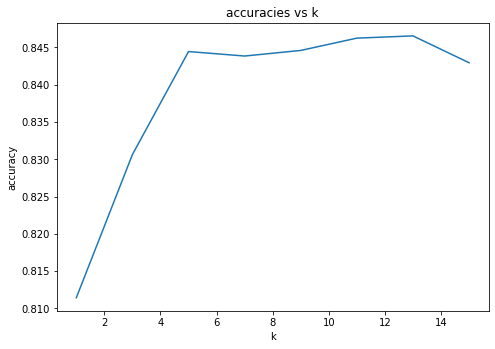

In [7]:
# Train/Predict with normalization using k=1,3,...,15

accuracies = []

for g in range(1,16, 2):
    accuracies.append(knn_mt_n.score(Xmt_test, ymt_test, g))

# Graph classification accuracy over k

ks = np.arange(1, 16, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ks, accuracies)
ax.set_title("accuracies vs k")
ax.set_xlabel("k")
ax.set_ylabel("accuracy")

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


Text(0, 0.5, 'MSE')

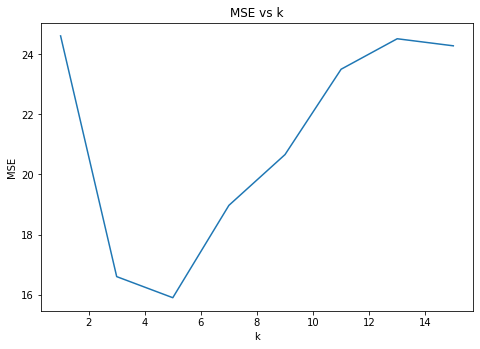

In [8]:
# Load housing price prediction data

data = arff.loadarff('datasets/housing_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xh = data[:,:-1].astype(np.float64)
yh = data[:,-1].astype(np.float64)

knn_h = KNNClassifier([], None, True, True)

knn_h.fit(Xh,yh)

data = arff.loadarff('datasets/housing_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

Xh_test = data[:,:-1].astype(np.float64)
yh_test = data[:,-1].astype(np.float64)

# Train/Predict using k=1,3,...,15

accuracies = []

for g in range(1,16, 2):
    accuracies.append(knn_h.score(Xh_test, yh_test, g))

# Graph MSE over k

ks = np.arange(1, 16, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ks, accuracies)
ax.set_title("MSE vs k")
ax.set_xlabel("k")
ax.set_ylabel("MSE")

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


Text(0, 0.5, 'MSE')

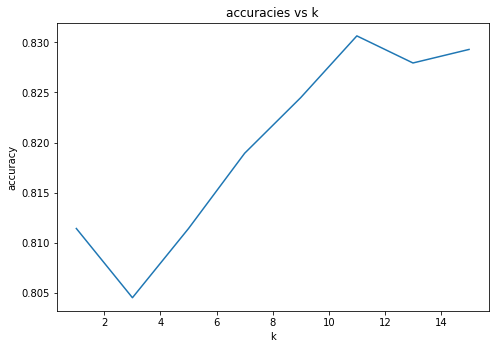

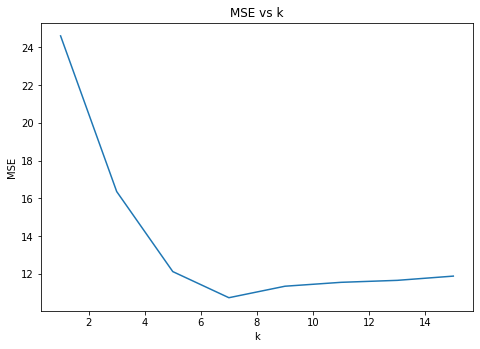

In [9]:
# Train/Predict magic telescope using distance-weighted voting

knn_mt_w = KNNClassifier([], 'inverse_distance', False, True)

knn_mt_w.fit(Xmt, ymt)

accuracies = []

for g in range(1,16, 2):
    accuracies.append(knn_mt_w.score(Xmt_test, ymt_test, g))

# Graph classification accuracy over k

ks = np.arange(1, 16, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ks, accuracies)
ax.set_title("accuracies vs k")
ax.set_xlabel("k")
ax.set_ylabel("accuracy")

# Train/Predict housing using distance-weighted voting

knn_h_w = KNNClassifier([], 'inverse_distance', True, True)

knn_h_w.fit(Xh, yh)

accuracies = []

for g in range(1,16, 2):
    accuracies.append(knn_h_w.score(Xh_test, yh_test, g))

# Graph MSE over k

ks = np.arange(1, 16, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ks, accuracies)
ax.set_title("MSE vs k")
ax.set_xlabel("k")
ax.set_ylabel("MSE")

For the magic telescope data, it appears that the the unwieghted algorithm gives better accuracies but as you use a larger k value the accuracy starts to decrease whereas the accuracy with the distance weighted algorithm tends to increase with larger k values. The MSE for the housing data set is much better when using the weighted version as opposed to the unweighted as k increases. It appears that classification works better with the unweighted version and regression works better with the weighted version.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [10]:
# Load dataset and split into train/test sets

# Train/Predict credit-approval


*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [11]:
# Train/Predict magic telescope using scikit's KNN

sk_knn_mt = KNeighborsClassifier(n_neighbors=15, weights='distance')

le = LabelEncoder()
sk_ymt = np.ravel(ymt.copy(), order='C')
le.fit(sk_ymt)
sk_ymt = le.transform(sk_ymt)

sk_knn_mt.fit(Xmt,sk_ymt)

le = LabelEncoder()
sk_ymt_test = np.ravel(ymt_test.copy(), order='C')
le.fit(sk_ymt_test)
sk_ymt_test = le.transform(sk_ymt_test)

print(sk_knn_mt.score(Xmt_test,sk_ymt_test))

# Train/Predict housing using scikit's KNN

sk_knn_h = KNeighborsRegressor(n_neighbors=73, weights='distance')

le = LabelEncoder()
sk_yh = np.ravel(yh.copy(), order='C')
le.fit(sk_yh)
sk_yh = le.transform(sk_yh)

sk_knn_h.fit(Xh,sk_yh)

le = LabelEncoder()
sk_yh_test = np.ravel(yh_test.copy(), order='C')
le.fit(sk_yh_test)
sk_yh_test = le.transform(sk_yh_test)

print(sk_knn_h.score(Xh_test,sk_yh_test))

0.8244824482448245
-42.3940986505798


The best accuracy with the scikit learn's classifier on the magic telescope data I could find was when I used 15 neighbors and had the weight set to distance. This is a similar k value to what I found was best with my algorithm although my algorithm did better with uniform weights. This makes me wonder if the algorithm I used to determine the weight based on the distance is different from what scikit learn uses. My algorithm scored higher than the scikit learn algorithm.

For the housing dataset, using the regressor, I found that having a higher k (73 was the best I found) and setting weights to distance helped improve the score. I am not sure how scikit learn calculated their score but I figured a less negative number was better. Because I am not sure what their scoring metric is, I can't compare it to the results that I got with my algorithm.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
